# Modelos de difusão

In [1]:
import networkx as nx
import numpy  as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

## Modelos de contágio complexo


Em todos os modelos nas seções anteriores, um só nó infectado pode contagiar um outro nó. 

Porém, em algumas situações faz sentido que sejam necessários mais vértices para contagiar um nó. 

Por exemplo, nos modelos de formação de opinião é comum que um nó seja influenciado por vários vizinhos e não troque de opinião se a pressão social não fosse suficiente. 

Este tipo de modelos é conhecido como de contágio complexo.

### Exemplo

Considere um modelo similar ao SI com um novo parâmetro $\rho>0$ que descreve a resistência de um vértice a infectar-se. 

Em particular, um vértice suscetível $i$ se infecta com uma probabilidade igual a

\begin{equation*}
p_i = \max\left\{\left(\# \text{vizinhos infectados de }i \right)\times \beta - \rho, 0\right\},
\end{equation*}

onde $\beta$ é a probabilidade de infecção por padrão. 

É claro que um vértice pode virar infectado só se o número de vizinhos infectados é maior do que $\rho/\beta$. 

O script a seguir mostra o que acontece quando o valor de $\rho$ muda.

In [2]:
# retorna o número de infectados

def numinf(g):    
    num = 0
    for n in g.nodes:
        if g.nodes[n]['estado'] == 1:
            num += 1

    return num

In [3]:
# retorna o número de vizinhos infectados

def numinfviz(g,n):
    num = 0
    for m in nx.neighbors(g,n):
        if g.nodes[m]['estado'] == 1:
            num += 1
    
    return num

In [4]:
# modelo CSI

def csi(g,beta,M,rng):
    delta = [0]*(M+1)
    delta[0] = numinf(g)/g.order()

    for k in range(M):
        for n in g.nodes:
            # o vértice é suscetível?
            if g.nodes[n]['estado'] == 0:
                p = beta*numinfviz(g,n)-g.nodes[n]['resistencia'] # probabilidade de contágio
                if rng.random() < p: # o vértice contagia-se?
                    g.nodes[n]['estado-prox'] = 1
                else:
                    g.nodes[n]['estado-prox'] = 0
                    
        num = 0
        for n in g.nodes:
            if g.nodes[n]['estado'] == 0:
                g.nodes[n]['estado'] = g.nodes[n]['estado-prox']
            if g.nodes[n]['estado'] == 1:
                num += 1
        delta[k+1] = num/g.order()
        
    return delta

In [5]:
def init(g,p,r,rng):
    for n in g.nodes:
        g.nodes[n]['estado-prox'] = 0
        g.nodes[n]['resistencia'] = r
        if rng.random() < p:
            g.nodes[n]['estado'] = 1 #I = 1
        else:
            g.nodes[n]['estado'] = 0 #S = 0

In [6]:
# rede de Barabási-Albert com 1000 nós e $m=3$
G3 = nx.barabasi_albert_graph(1000,3)

In [8]:
rng = default_rng()

#aproximadamente um 10% dos vértices estão inicialmente infectados
init(G3,0.1,0.3,rng)
dens1 = csi(G3,0.1,200,rng)

init(G3,0.1,0.5,rng)
dens2 = csi(G3,0.1,200,rng)

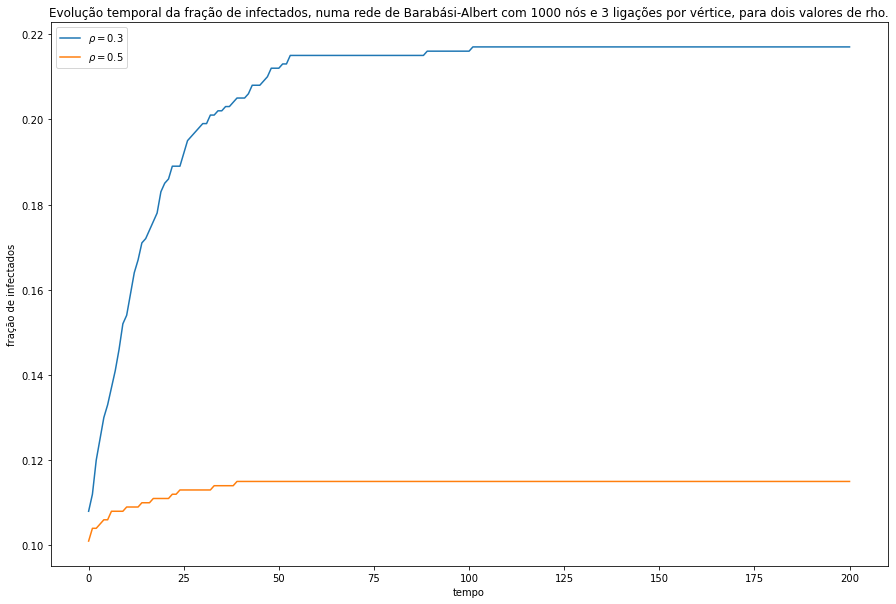

In [9]:
fig = plt.subplots(1,1,figsize=(15,10))

plt.plot(dens1,label=r'$\rho = 0.3$')
plt.plot(dens2,label=r'$\rho = 0.5$')
plt.legend()
plt.xlabel('tempo')
plt.ylabel('fração de infectados')
plt.title('Evolução temporal da fração de infectados, numa rede de Barabási-Albert com 1000 nós e 3 ligações por vértice, para dois valores de rho.')
plt.show()

Nem todos os vértices precisam ter a mesma resistência a infecção. 

Às vezes, é razoável supor que os nós têm resistências com uma distribuição definida. 

O seguinte exemplo analisa a influência da média da resistência com uma distribuição Gaussiana com desvio $=0.05$.

In [10]:
def initr(g,p,media,desvio,rng):
    for n in g.nodes:
        g.nodes[n]['estado-prox'] = 0
        g.nodes[n]['resistencia'] = rng.normal(loc=media,scale=desvio)
        if rng.random() < p:
            g.nodes[n]['estado'] = 1 #I = 1
        else:
            g.nodes[n]['estado'] = 0 #S = 0

In [11]:
media = np.linspace(0.3,1,8)
desvio= 0.05
den = np.zeros((100,media.shape[0]))

for k in range(media.shape[0]):
    for i in range(100):
        g = nx.barabasi_albert_graph(1000,3)
        initr(g,0.1,media[k],desvio,rng)
        dens = csi(g,0.1,200,rng)
        den[i,k] = dens[-1]
    print(k,den[i,k])
    

0 0.505
1 0.15
2 0.124
3 0.102
4 0.097
5 0.096
6 0.109
7 0.106


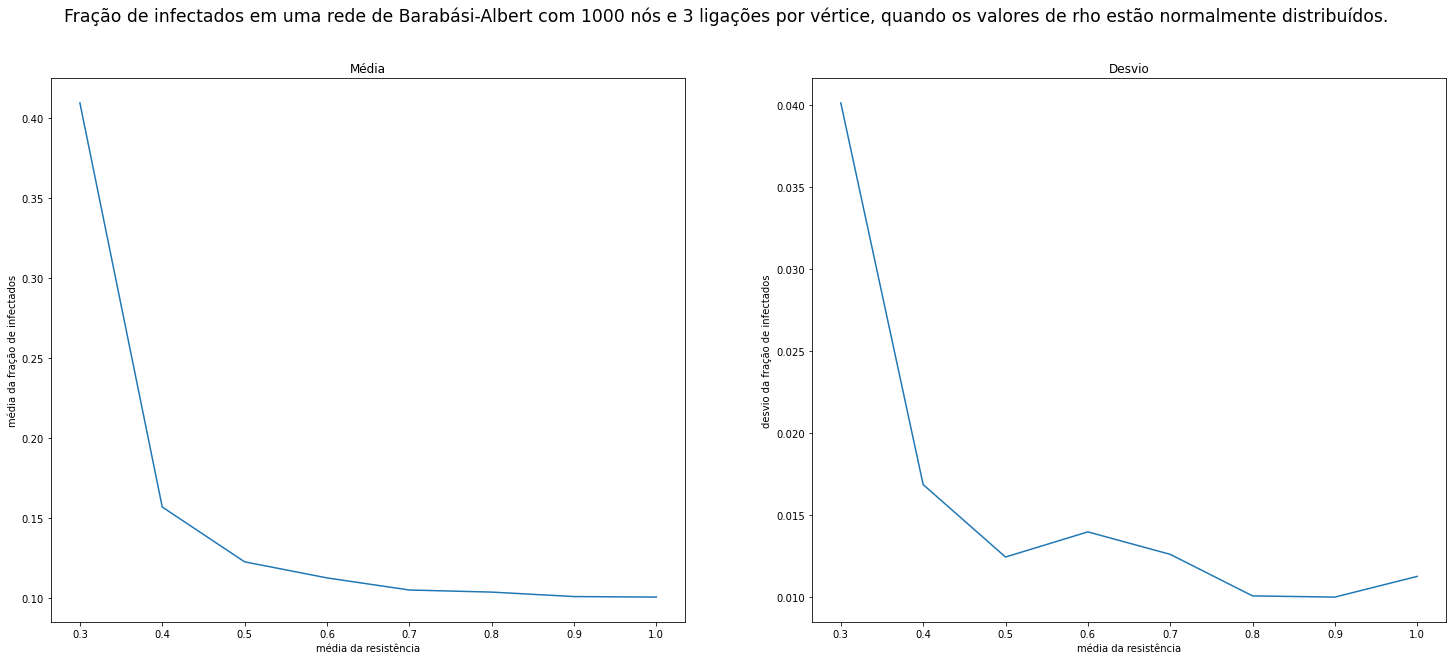

In [12]:
mden = np.mean(den,axis=0)
sden = np.std(den,axis=0,ddof=1)

fig, axs = plt.subplots(1,1,figsize=(25,10))

plt.figure(1)
plt.subplot(121)
plt.plot(media,mden)
plt.xlabel('média da resistência')
plt.ylabel('média da fração de infectados')
plt.title('Média')

#plt.figure()
plt.subplot(122)
plt.plot(media,sden)
plt.xlabel('média da resistência')
plt.ylabel('desvio da fração de infectados')
plt.title('Desvio')

fig.suptitle('Fração de infectados em uma rede de Barabási-Albert com 1000 nós e 3 ligações por vértice, quando os valores de rho estão normalmente distribuídos.', fontsize='xx-large')
plt.show()